<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [510]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [511]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-06-26 19:14:20--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2020-06-26 19:14:20 (304 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [512]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [513]:
df.shape

(346, 10)

### Convert to date time object 

In [514]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [515]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


In [516]:
df['Gender'].value_counts()

male      294
female     52
Name: Gender, dtype: int64

Lets plot some columns to underestand data better:

In [517]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



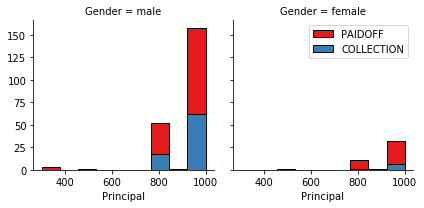

In [518]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

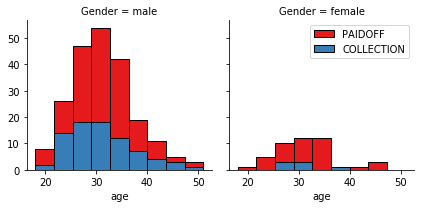

In [519]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

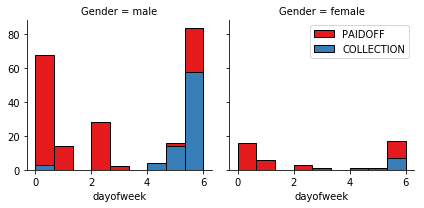

In [520]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [521]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [522]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [523]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [524]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [525]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame 

In [526]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [527]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [528]:
type(X)

pandas.core.frame.DataFrame

What are our lables?

In [529]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [530]:
type(y)

numpy.ndarray

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [531]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

In [532]:
#Importing all models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [533]:
#Splitting data into train_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (276, 8)
X_test:  (70, 8)
y_train:  (276,)
y_test:  (70,)


# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [534]:
k_and_acc_train = dict()
k_and_acc_test = dict()

#Finding best k
for k in range(1,10):
    
    #defining the model
    kNN = KNeighborsClassifier(n_neighbors = k)
    kNN.fit(X_train, y_train)
    
    #calculating accuracies
    train_acc = accuracy_score(y_train, kNN.predict(X_train))
    test_acc = accuracy_score(y_test, kNN.predict(X_test))
    
    #saving the train and test accuracy along with k in dict
    k_and_acc_train[k] = train_acc
    k_and_acc_test[k] = test_acc

best_k_for_train = max(k_and_acc_train, key = k_and_acc_train.get)
best_k_for_test = max(k_and_acc_test, key = k_and_acc_test.get)

print("best_k_for_train: ", best_k_for_train) #should be 1
print("best_k_for_test: ", best_k_for_test) #should be 6

best_k_for_train:  1
best_k_for_test:  6


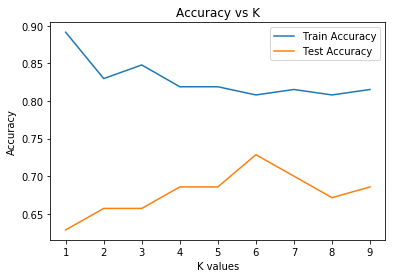

In [535]:
#Plotting the Accuracy with changing parameters
k = [x for x in range(1, 10)]
plt.plot(np.array(k), k_and_acc_train.values(), '-', label = "Train Accuracy")
plt.plot(np.array(k), k_and_acc_test.values(), '-', label = "Test Accuracy")
plt.title('Accuracy vs K')
plt.xlabel('K values')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Since our ultimate motive is to select a 'k' that works best for test data (which is previously unknown), we select best_k = best_k_for_test. Then we retrain our KNN model with the best_k.


In [536]:
best_k = best_k_for_test
kNN = KNeighborsClassifier(n_neighbors = best_k).fit(X_train, y_train)

# Decision Tree

In [537]:
depth_acc = dict()

for d in range(1, 10):
    #defining the model
    DTree = DecisionTreeClassifier(criterion="entropy", max_depth = d, random_state = 7)
    DTree.fit(X_train, y_train)
    #calculating accuracy and storing in dict
    depth_acc[d] = accuracy_score(y_test, DTree.predict(X_test))
    
best_depth = max(depth_acc, key = depth_acc.get)
print('best depth: ', best_depth)

best depth:  1


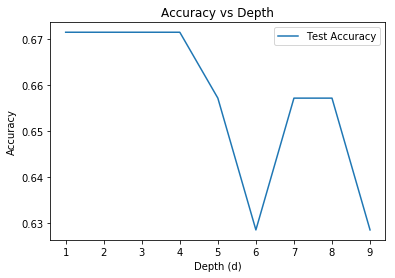

In [538]:
#Plotting the Accuracy with changing parameters
d = [x for x in range(1, 10)]
plt.plot(np.array(d), depth_acc.values(), '-', label = "Test Accuracy")
plt.title('Accuracy vs Depth')
plt.xlabel('Depth (d)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [539]:
#Retrain with best_depth
DTree = DecisionTreeClassifier(criterion="entropy", max_depth = best_depth, random_state = 7).fit(X, y)

# Support Vector Machine

In [540]:
kernel_acc = dict()

for kernel in ['rbf', 'poly', 'sigmoid', 'linear']: 
    #defining the model
    vector = svm.SVC(kernel = kernel, random_state = 7)
    vector.fit(X_train, y_train)
    #calculating accuracy and storing in dict
    kernel_acc[kernel] = accuracy_score(y_test, vector.predict(X_test))
    
best_kernel = max(kernel_acc, key = kernel_acc.get)
print('best kernel: ', best_kernel)

best kernel:  rbf


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


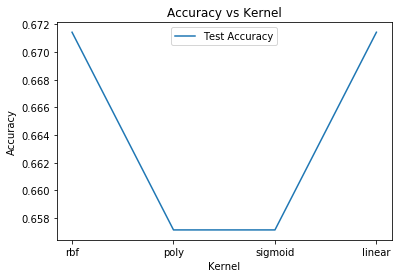

In [541]:
#Plotting the Accuracy with changing parameters
knl = ['rbf', 'poly', 'sigmoid', 'linear']
plt.plot(np.array(knl), kernel_acc.values(), '-', label = "Test Accuracy")
plt.title('Accuracy vs Kernel')
plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [542]:
#Retrain with best_kernel
vector = svm.SVC(kernel = best_kernel, random_state = 7).fit(X, y)

# Logistic Regression

In [543]:
solver_acc = dict()

for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    #defining the model
    Logit = LogisticRegression(solver = solver)
    Logit.fit(X_train, y_train)
    #calculating accuracy and storing in dict
    solver_acc[solver] = accuracy_score(y_test, Logit.predict(X_test))
    
best_solver = max(solver_acc, key = solver_acc.get)
print('best solver: ', best_solver)



best solver:  newton-cg


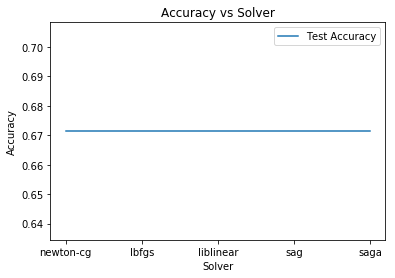

In [544]:
#Plotting the Accuracy with changing parameters
slv = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
plt.plot(np.array(slv), solver_acc.values(), '-', label = "Test Accuracy")
plt.title('Accuracy vs Solver')
plt.xlabel('Solver')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

###### Actually all solvers give same accuracy, so we can use any

In [545]:
#Retrain with best_solver
Logit = LogisticRegression(solver = best_solver).fit(X, y)

# Model Evaluation using Test set

In [546]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report

First, download and load the test set:

In [547]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-06-26 19:17:39--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-06-26 19:17:39 (307 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [548]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Preparing test data same as we did with test data before training

In [549]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [550]:
print(Feature.shape)
X_test = Feature
X_test = preprocessing.StandardScaler().fit_transform(X_test)
y_test = test_df['loan_status'].values
print("X_test.shape", X_test.shape)
print("y_test.shape", y_test.shape)

(54, 8)
X_test.shape (54, 8)
y_test.shape (54,)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Predicting

In [551]:
y_hat_KNN = kNN.predict(X_test)
y_hat_Tre = DTree.predict(X_test)
y_hat_SVM = vector.predict(X_test)
y_hat_Log = Logit.predict(X_test)
y_hat_prob_Log = Logit.predict_proba(X_test)

### Generating Score Report

In [552]:
jac_scores = list()
f1_scores = list()
logloss = list()

#Stroing jac scores of all model in a list
jac_scores.append(jaccard_similarity_score(y_test, y_hat_KNN))
jac_scores.append(jaccard_similarity_score(y_test, y_hat_Tre))
jac_scores.append(jaccard_similarity_score(y_test, y_hat_SVM))
jac_scores.append(jaccard_similarity_score(y_test, y_hat_Log))

#Stroing f1 scores of all model in a list
f1_scores.append(f1_score(y_test, y_hat_KNN, average='weighted'))
f1_scores.append(f1_score(y_test, y_hat_Tre, average='weighted'))
f1_scores.append(f1_score(y_test, y_hat_SVM, average='weighted'))
f1_scores.append(f1_score(y_test, y_hat_Log, average='weighted'))

#Stroing log loss values of all model in a list
logloss.append(None)
logloss.append(None)
logloss.append(None)
logloss.append(log_loss(y_test, y_hat_prob_Log))


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [553]:
report = pd.DataFrame({'Jaccard': jac_scores, 'F1-score':f1_scores, 'LogLoss': logloss},
        index = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression'])
report

,Jaccard,F1-score,LogLoss
KNN,0.722222,0.718793,NaN
Decision Tree,0.740741,0.630418,NaN
SVM,0.722222,0.621266,NaN
Logistic Regression,0.759259,0.671764,0.480808


# Builtin Classification Reports
#### It is clear from the reports that although the accuracy for models are relatively higher, the label imballance causes one class to be learned too well as compared to the other one. From among all these KNN is the most suitible as it's f1_score for 'COLLECTION' is the highest 44% as compared to 0%, 0% and 14% for DTree, SVM, and Logit. 'PAIDOFF' has great f1_Scores for all models so it does not matter. More data can be used in traiing to improve this 44% score.

### KNN

In [554]:
print(classification_report(y_test, y_hat_KNN))

              precision    recall  f1-score   support

  COLLECTION       0.46      0.43      0.44        14
     PAIDOFF       0.80      0.82      0.81        40

   micro avg       0.72      0.72      0.72        54
   macro avg       0.63      0.63      0.63        54
weighted avg       0.72      0.72      0.72        54



### Decision Tree

In [555]:
print(classification_report(y_test, y_hat_Tre))

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        14
     PAIDOFF       0.74      1.00      0.85        40

   micro avg       0.74      0.74      0.74        54
   macro avg       0.37      0.50      0.43        54
weighted avg       0.55      0.74      0.63        54



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### SVM

In [556]:
print(classification_report(y_test, y_hat_SVM))

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        14
     PAIDOFF       0.74      0.97      0.84        40

   micro avg       0.72      0.72      0.72        54
   macro avg       0.37      0.49      0.42        54
weighted avg       0.55      0.72      0.62        54



### Logitic Regression

In [557]:
print(classification_report(y_test, y_hat_Log))

              precision    recall  f1-score   support

  COLLECTION       1.00      0.07      0.13        14
     PAIDOFF       0.75      1.00      0.86        40

   micro avg       0.76      0.76      0.76        54
   macro avg       0.88      0.54      0.50        54
weighted avg       0.82      0.76      0.67        54



# Extra: Improving the score for Logistic Regression
I am using prediced probability *(y_hat_prob_Log)* of each output label *(y_hat_Log)* to improve the accuracy scores by changing the default threshold value of *y_hat_prob_Log* from 0.5 to 0.55, which was concluded from the plot below.

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


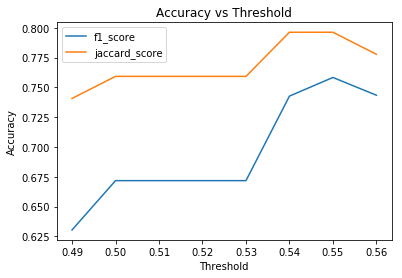

In [558]:
from sklearn.preprocessing import binarize

#Array contains y_hat_Log_2 output labels for different threshold
y_hat_Log_2_arr = list() #
values = [0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56]
for i in range(8):
    y_hat_Log_2_arr.append(binarize(y_hat_prob_Log, values[i])[:,1])
    
#Because we used binarizer on probabilities (y_hat_prob_Log) to make y_hat_Log_2, we must convert y_test to binary     
y_test_temp = pd.DataFrame(y_test)
y_test_temp = y_test_temp.replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=False)

#Arrays of scores for different y_hat_Log_2 in array with changing thresholds
f1s = list()
jacs = list()
for j in range(8):
    f1s.append(f1_score(y_test_temp, y_hat_Log_2_arr[j], average='weighted'))
    jacs.append(jaccard_similarity_score(y_test_temp, y_hat_Log_2_arr[j]))
    
#Plotting Accuracy Scores Vs Changing Thresholds
plt.plot(np.array(values), f1s, '-', label = 'f1_score')
plt.plot(values, jacs, '-', label = 'jaccard_score')
plt.title('Accuracy vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [559]:
#With above threshold value of 0.55 our new better scores for Logit are:
y_hat_Log_2 = binarize(y_hat_prob_Log,0.55)[:,1] #Improved version of y_hat_log
print("New f1_score: ", f1_score(y_test_temp, y_hat_Log_2, average='weighted'))
print("New jac_score: ", jaccard_similarity_score(y_test_temp, y_hat_Log_2))

print('\n')
print('\t\t  New Report for Logits')
print(classification_report(y_test_temp, y_hat_Log_2))

New f1_score:  0.7583503077293734
New jac_score:  0.7962962962962963


		  New Report for Logits
              precision    recall  f1-score   support

           0       0.80      0.29      0.42        14
           1       0.80      0.97      0.88        40

   micro avg       0.80      0.80      0.80        54
   macro avg       0.80      0.63      0.65        54
weighted avg       0.80      0.80      0.76        54



##### We conclude that:
* For Logits, we have improved f1_scores of 'COLLECTION' from 13% to 42% and for 'PAIDOFF' from 86% to 88%. 
* Still KNN takes the lead with minor lead in 'COLLECTION' at 44% but loses to Logits with 81% in 'PAIDOFF'. 
* Regardless, KNN is better for us as detecting 'COLLECTION' is our primary motive.

##### Therefore the updated scores are given below.

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.72    | 0.72     | NA      |
| Decision Tree      | 0.74    | 0.63     | NA      |
| SVM                | 0.72    | 0.62     | NA      |
| LogisticRegression | 0.80    | 0.76     | 0.48    |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>